In [41]:
import ee
service_account = 'clgx-gis-app-dev-06e3@appspot.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'clgx-gis-app-dev-06e3-a1a85a16331a.json')
ee.Initialize(credentials)



In [42]:
import geopandas as gpd
import pandas as pd
import geojson
from shapely import wkt
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [43]:
startDate = '2020-06-01'
endDate = '2021-06-16'
chartMin = -30
chartMax = 0
orbitProperties_pass = 'DESCENDING'

In [44]:
bbox = gpd.read_file('boulder_bounds.shp')
coords = list(bbox['geometry'][0].exterior.coords)

# drop z values
coords = [list(c[:2]) for c in coords]

aoi = ee.Geometry.Polygon(coords)


In [45]:
def image_mask(image):
    edge = image.lt(-30.0)
    maskedImage = image.updateMask(edge.Not())
    return image.updateMask(maskedImage)

In [46]:
s1 = ee.ImageCollection('COPERNICUS/S1_GRD')
images = (s1.filterDate(startDate, endDate).
            filterMetadata('instrumentMode', 'equals', 'IW').
            filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass)).
            filterBounds(aoi).
            filter(ee.Filter.eq('resolution_meters', 10))
            
)


In [47]:
image_count = images.size().getInfo()   
print('Number of images: ', image_count)

Number of images:  62


In [48]:
composite = images.mean()
composite = composite.clip(aoi)

In [49]:
composite.getInfo()

{'type': 'Image',
 'bands': [{'id': 'VV',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 2],
   'origin': [-106, 39],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [2, 2],
   'origin': [-106, 39],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'angle',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [2, 2],
   'origin': [-106, 39],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}],
 'properties': {'system:footprint': {'type': 'Polygon',
   'coordinates': [[[-105.23134908199995, 40.05088386700004],
     [-105.23180764799997, 40.01482384700006],
     [-105.16327276799996, 40.014573720000044],
     [-105.16393977399997, 40.05000842100003],
     [-105.23134908199995, 40.05088386700004]]]}}}

Land Cover Mapping

In [50]:
worldcover = ee.ImageCollection('ESA/WorldCover/v200').first()

In [51]:
classified = worldcover.remap(
  [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100],
  [0,  1 , 2,  3,  4,  5,  6,  7,  8,  9,  10]).rename('classification')

In [52]:
boulder_lc = classified.clip(aoi)

In [53]:
boulder_lc.getInfo()

{'type': 'Image',
 'bands': [{'id': 'classification',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 10},
   'dimensions': [825, 438],
   'origin': [897217, 527388],
   'crs': 'EPSG:4326',
   'crs_transform': [8.333333333333333e-05,
    0,
    -180,
    0,
    -8.333333333333333e-05,
    84]}],
 'version': 1685064899986242,
 'id': 'ESA/WorldCover/v200/2021',
 'properties': {'system:footprint': {'type': 'Polygon',
   'coordinates': [[[-105.23134908199995, 40.05088386700004],
     [-105.23180764799997, 40.01482384700006],
     [-105.16327276799996, 40.014573720000044],
     [-105.16393977399997, 40.05000842100003],
     [-105.23134908199995, 40.05088386700004]]]},
  'Map_class_names': ['Tree cover',
   'Shrubland',
   'Grassland',
   'Cropland',
   'Built-up',
   'Bare / sparse vegetation',
   'Snow and ice',
   'Permanent water bodies',
   'Herbaceous wetland',
   'Mangroves',
   'Moss and lichen'],
  'system:time_start': 1609455600000,
  'system:time_end': 1

In [54]:
# display boulder lc using folium
import folium
from folium import plugins

# get the map center
center = aoi.centroid().coordinates().getInfo()[::-1]

# get bounds
bounds = aoi.bounds().getInfo()['coordinates']

# get the map bounds
map_bounds = [bounds[0][0][::-1], bounds[0][2][::-1]]

# create the map
m = folium.Map(location=center, zoom_start=12)

# add the bounds to the map
m.fit_bounds([map_bounds])



In [55]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [56]:
# add aoi to map
m.add_ee_layer(aoi, {}, 'aoi')

In [57]:
vis_params = {'palette': ['006400',
   'ffbb22',
   'ffff4c',
   'f096ff',
   'fa0000',
   'b4b4b4',
   'f0f0f0',
   '0064c8',
   '0096a0',
   '00cf75',
   'fae6a0']
    }

In [58]:
#m.add_ee_layer(boulder_lc, vis_params, 'boulder_lc')
m.add_ee_layer(composite, {}, 'composite')

In [59]:
m.add_child(folium.LayerControl())

In [302]:
worldCoverClassNames= [
  'Tree Cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up',
  'Bare / sparse Vegetation', 'Snow and Ice', 
  'Permanent Water Bodies', 'Herbaceous Wetland', 
  'Mangroves', 'Moss and Lichen']

worldCoverPalette = [
'006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000',
'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75',
'fae6a0']

classNames = ee.Dictionary.fromLists(
  ['0','1','2','3','4','5','6','7','8','9', '10'],
  worldCoverClassNames
)

classColors = ee.Dictionary.fromLists(
  ['0','1','2','3','4','5','6','7','8','9', '10'],
  worldCoverPalette
)

In [303]:
classNames.getInfo()

{'0': 'Tree Cover',
 '1': 'Shrubland',
 '10': 'Moss and Lichen',
 '2': 'Grassland',
 '3': 'Cropland',
 '4': 'Built-up',
 '5': 'Bare / sparse Vegetation',
 '6': 'Snow and Ice',
 '7': 'Permanent Water Bodies',
 '8': 'Herbaceous Wetland',
 '9': 'Mangroves'}

In [304]:
classNames = classNames.getInfo()
# convert keys to str
classNames = {str(k):v for k,v in classNames.items()}
# create an ee.Dictionary
classNames = ee.Dictionary(classNames)

classNames.getInfo()

{'0': 'Tree Cover',
 '1': 'Shrubland',
 '10': 'Moss and Lichen',
 '2': 'Grassland',
 '3': 'Cropland',
 '4': 'Built-up',
 '5': 'Bare / sparse Vegetation',
 '6': 'Snow and Ice',
 '7': 'Permanent Water Bodies',
 '8': 'Herbaceous Wetland',
 '9': 'Mangroves'}

Sampling

In [305]:
# reporject imagery to epsg 32613
boulder_lc = boulder_lc.reproject(crs='EPSG:32613', scale=10)
composite = composite.reproject(crs='EPSG:32613', scale=10)

In [306]:
all_bands = composite.addBands(boulder_lc)

In [307]:
all_bands.select('classification').getInfo()

{'type': 'Image',
 'bands': [{'id': 'classification',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 10},
   'dimensions': [589, 408],
   'origin': [48020, -443345],
   'crs': 'EPSG:32613',
   'crs_transform': [10, 0, 0, 0, -10, 0]}],
 'properties': {'system:footprint': {'type': 'Polygon',
   'coordinates': [[[-105.23134908199995, 40.05088386700004],
     [-105.23180764799997, 40.01482384700006],
     [-105.16327276799996, 40.014573720000044],
     [-105.16393977399997, 40.05000842100003],
     [-105.23134908199995, 40.05088386700004]]]}}}

In [311]:
samples = (all_bands
  .stratifiedSample(
    numPoints=50,
    classBand='classification',
    projection='EPSG:32613',
    scale=10
  )
)

In [312]:
#samples = samples.getInfo()
samples.getInfo()

{'type': 'FeatureCollection',
 'columns': {'VH': 'Float',
  'VV': 'Float',
  'angle': 'Float',
  'classification': 'Byte<0, 10>'},
 'properties': {'band_order': ['VV', 'VH', 'angle', 'classification']},
 'features': [{'type': 'Feature',
   'geometry': None,
   'id': '0',
   'properties': {'VH': -13.595390822355442,
    'VV': -6.818728538385495,
    'angle': 38.43422317504883,
    'classification': 0}},
  {'type': 'Feature',
   'geometry': None,
   'id': '1',
   'properties': {'VH': -17.667224231603683,
    'VV': -11.19682184526405,
    'angle': 38.422828674316406,
    'classification': 0}},
  {'type': 'Feature',
   'geometry': None,
   'id': '2',
   'properties': {'VH': -21.60431080753059,
    'VV': -13.097702929688964,
    'angle': 38.455589294433594,
    'classification': 0}},
  {'type': 'Feature',
   'geometry': None,
   'id': '3',
   'properties': {'VH': -19.059533053818804,
    'VV': -13.954636102460032,
    'angle': 38.47877502441406,
    'classification': 0}},
  {'type': 'Featur

In [313]:
bands = composite.bandNames()

In [314]:
properties = bands.add('classification')
properties.getInfo()

['VV', 'VH', 'angle', 'classification']

In [315]:
numBands = bands.length()

In [316]:
groupIndex = properties.indexOf('classification')
#groupIndex = ee.Number(4)

In [317]:
print('Band names: ', bands.getInfo())
print('Number of bands: ', numBands.getInfo())
print('Grouped by band index: ', groupIndex.getInfo())

Band names:  ['VV', 'VH', 'angle']
Number of bands:  3
Grouped by band index:  3


In [318]:

allReducers = (ee.Reducer.median()
  .combine(reducer2=ee.Reducer.min(), sharedInputs=True)
  .combine(reducer2=ee.Reducer.max(), sharedInputs=True)
  .combine(reducer2=ee.Reducer.percentile([25]), sharedInputs=True)
  .combine(reducer2=ee.Reducer.percentile([75]), sharedInputs=True)
)

In [319]:
stats = (samples.reduceColumns(
    selectors=properties,
    reducer=allReducers.repeat(numBands).group(
    groupField=groupIndex))
)

In [320]:
stats.getInfo()

{'groups': [{'group': 0,
   'max': [-6.818728538385495, -13.595390822355442, 38.568382263183594],
   'median': [-11.239455780636488, -17.633707649776483, 38.4447021484375],
   'min': [-17.13621307428928, -23.51341691593597, 38.23530578613281],
   'p25': [-12.149683929953623, -19.18569845734051, 38.37693405151367],
   'p75': [-10.185646443189233, -16.709858486686553, 38.499149322509766]},
  {'group': 1,
   'max': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
   'median': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
   'min': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
   'p25': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
   'p75': [-10.71281245409642, -16.597716325050392, 38.47945785522461]},
  {'group': 2,
   'max': [-4.340848451820602, -16.0334768730906, 38.590335845947266],
   'median': [-15.205569728232863, -22.931845411635962, 38.40915870666504],
   'min': [-18.01068995626699, -26.690231290266464, 38.2436943054199

In [321]:
groupStats = ee.List(stats.get('groups'))
print('Group stats: ', groupStats.getInfo())

Group stats:  [{'group': 0, 'max': [-6.818728538385495, -13.595390822355442, 38.568382263183594], 'median': [-11.239455780636488, -17.633707649776483, 38.4447021484375], 'min': [-17.13621307428928, -23.51341691593597, 38.23530578613281], 'p25': [-12.149683929953623, -19.18569845734051, 38.37693405151367], 'p75': [-10.185646443189233, -16.709858486686553, 38.499149322509766]}, {'group': 1, 'max': [-10.71281245409642, -16.597716325050392, 38.47945785522461], 'median': [-10.71281245409642, -16.597716325050392, 38.47945785522461], 'min': [-10.71281245409642, -16.597716325050392, 38.47945785522461], 'p25': [-10.71281245409642, -16.597716325050392, 38.47945785522461], 'p75': [-10.71281245409642, -16.597716325050392, 38.47945785522461]}, {'group': 2, 'max': [-4.340848451820602, -16.0334768730906, 38.590335845947266], 'median': [-15.205569728232863, -22.931845411635962, 38.40915870666504], 'min': [-18.01068995626699, -26.690231290266464, 38.24369430541992], 'p25': [-16.395420977400295, -24.682

In [322]:
groupStats.getInfo()

[{'group': 0,
  'max': [-6.818728538385495, -13.595390822355442, 38.568382263183594],
  'median': [-11.239455780636488, -17.633707649776483, 38.4447021484375],
  'min': [-17.13621307428928, -23.51341691593597, 38.23530578613281],
  'p25': [-12.149683929953623, -19.18569845734051, 38.37693405151367],
  'p75': [-10.185646443189233, -16.709858486686553, 38.499149322509766]},
 {'group': 1,
  'max': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'median': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'min': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'p25': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'p75': [-10.71281245409642, -16.597716325050392, 38.47945785522461]},
 {'group': 2,
  'max': [-4.340848451820602, -16.0334768730906, 38.590335845947266],
  'median': [-15.205569728232863, -22.931845411635962, 38.40915870666504],
  'min': [-18.01068995626699, -26.690231290266464, 38.24369430541992],
  'p25': [-16.39542097

In [323]:
#stats = ee.List(['median', 'min', 'max', 'p25', 'p75'])
#bands = ee.List(['VV', 'VH'])

#def stats_out(stat):
#    keys = bands.map(lambda b: ee.String(b).cat('_').cat(stat))
#    return keys

#stats.map(stats_out).getInfo()


In [324]:
def itemDict(item):
    #properties = None
    itemDict_vals = ee.Dictionary(item)
    classNumber = itemDict_vals.get('group')
    
    stats = ee.List(['median', 'min', 'max', 'p25', 'p75'])
    
    def extract_keys(stat):
        return bands.map(lambda b: ee.String(b).cat('_').cat(stat))
    
    keys = stats.map(extract_keys).flatten()
    print(f'keys: {keys.length().getInfo()}')

    def extract_vals(stat):
        return itemDict_vals.get(stat)

    values = stats.map(extract_vals).flatten()

    properties = ee.Dictionary.fromLists(keys, values)
    properties = properties.set('classNumber', classNumber)
    properties = properties.set('className', classNames.get(ee.String(classNumber)))

    return properties



In [325]:
groupStats.getInfo()

[{'group': 0,
  'max': [-6.818728538385495, -13.595390822355442, 38.568382263183594],
  'median': [-11.239455780636488, -17.633707649776483, 38.4447021484375],
  'min': [-17.13621307428928, -23.51341691593597, 38.23530578613281],
  'p25': [-12.149683929953623, -19.18569845734051, 38.37693405151367],
  'p75': [-10.185646443189233, -16.709858486686553, 38.499149322509766]},
 {'group': 1,
  'max': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'median': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'min': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'p25': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'p75': [-10.71281245409642, -16.597716325050392, 38.47945785522461]},
 {'group': 2,
  'max': [-4.340848451820602, -16.0334768730906, 38.590335845947266],
  'median': [-15.205569728232863, -22.931845411635962, 38.40915870666504],
  'min': [-18.01068995626699, -26.690231290266464, 38.24369430541992],
  'p25': [-16.39542097

In [326]:
groupStats = groupStats.getInfo()
for item in groupStats:
    item['group'] = str(item['group'])

groupStats = ee.List(groupStats)
groupStats.getInfo()

[{'group': '0',
  'max': [-6.818728538385495, -13.595390822355442, 38.568382263183594],
  'median': [-11.239455780636488, -17.633707649776483, 38.4447021484375],
  'min': [-17.13621307428928, -23.51341691593597, 38.23530578613281],
  'p25': [-12.149683929953623, -19.18569845734051, 38.37693405151367],
  'p75': [-10.185646443189233, -16.709858486686553, 38.499149322509766]},
 {'group': '1',
  'max': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'median': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'min': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'p25': [-10.71281245409642, -16.597716325050392, 38.47945785522461],
  'p75': [-10.71281245409642, -16.597716325050392, 38.47945785522461]},
 {'group': '2',
  'max': [-4.340848451820602, -16.0334768730906, 38.590335845947266],
  'median': [-15.205569728232863, -22.931845411635962, 38.40915870666504],
  'min': [-18.01068995626699, -26.690231290266464, 38.24369430541992],
  'p25': [-16.39

In [327]:
spectralStats = groupStats.map(itemDict)

keys: 15
keys: 15
keys: 15


In [328]:
spectralStats.getInfo()   

[{'VH_max': -13.595390822355442,
  'VH_median': -17.633707649776483,
  'VH_min': -23.51341691593597,
  'VH_p25': -19.18569845734051,
  'VH_p75': -16.709858486686553,
  'VV_max': -6.818728538385495,
  'VV_median': -11.239455780636488,
  'VV_min': -17.13621307428928,
  'VV_p25': -12.149683929953623,
  'VV_p75': -10.185646443189233,
  'angle_max': 38.568382263183594,
  'angle_median': 38.4447021484375,
  'angle_min': 38.23530578613281,
  'angle_p25': 38.37693405151367,
  'angle_p75': 38.499149322509766,
  'className': 'Tree Cover',
  'classNumber': '0'},
 {'VH_max': -16.597716325050392,
  'VH_median': -16.597716325050392,
  'VH_min': -16.597716325050392,
  'VH_p25': -16.597716325050392,
  'VH_p75': -16.597716325050392,
  'VV_max': -10.71281245409642,
  'VV_median': -10.71281245409642,
  'VV_min': -10.71281245409642,
  'VV_p25': -10.71281245409642,
  'VV_p75': -10.71281245409642,
  'angle_max': 38.47945785522461,
  'angle_median': 38.47945785522461,
  'angle_min': 38.47945785522461,
  'ang

### plotting in seaborn matplotlib

In [329]:
df = pd.DataFrame(spectralStats.getInfo())

In [330]:
df

,VH_max,VH_median,VH_min,VH_p25,VH_p75,VV_max,VV_median,VV_min,VV_p25,VV_p75,angle_max,angle_median,angle_min,angle_p25,angle_p75,className,classNumber
0,-13.595391,-17.633708,-23.513417,-19.185698,-16.709858,-6.818729,-11.239456,-17.136213,-12.149684,-10.185646,38.568382,38.444702,38.235306,38.376934,38.499149,Tree Cover,0
1,-16.597716,-16.597716,-16.597716,-16.597716,-16.597716,-10.712812,-10.712812,-10.712812,-10.712812,-10.712812,38.479458,38.479458,38.479458,38.479458,38.479458,Shrubland,1
2,-16.033477,-22.931845,-26.690231,-24.682472,-21.209628,-4.340848,-15.205570,-18.010690,-16.395421,-13.382163,38.590336,38.409159,38.243694,38.319813,38.487122,Grassland,2
3,-19.798782,-24.224847,-25.982466,-24.697154,-22.447561,-11.160771,-15.989811,-18.046266,-17.003061,-14.638301,38.581570,38.322176,38.229191,38.269375,38.477341,Cropland,3
4,-4.363721,-17.865177,-27.063416,-20.753600,-15.036844,4.130570,-9.510374,-18.592694,-12.983167,-6.225408,38.585854,38.526770,38.336170,38.480839,38.554203,Built-up,4
5,-13.520355,-21.216349,-25.796800,-23.425321,-17.898925,-2.892429,-11.669144,-18.513545,-14.498026,-8.017898,38.571606,38.446157,38.309227,38.430687,38.479431,Bare / sparse Vegetation,5
6,-20.235661,-28.192984,-29.538570,-28.515809,-27.385359,-12.673669,-22.181067,-23.511636,-22.581750,-21.103861,38.559769,38.383509,38.329700,38.362598,38.429493,Permanent Water Bodies,7


In [331]:
df.columns

Index(['VH_max', 'VH_median', 'VH_min', 'VH_p25', 'VH_p75', 'VV_max',
       'VV_median', 'VV_min', 'VV_p25', 'VV_p75', 'angle_max', 'angle_median',
       'angle_min', 'angle_p25', 'angle_p75', 'className', 'classNumber'],
      dtype='object')

In [332]:
# Melt the DataFrame to create a "variable" column that holds column names and a "value" column
melted_df_vh = pd.melt(df, id_vars=['className'], value_vars=['VH_max', 'VH_median', 'VH_min', 'VH_p25', 'VH_p75'])
melted_df_vv = pd.melt(df, id_vars=['className'], value_vars=['VV_max', 'VV_median', 'VV_min', 'VV_p25', 'VV_p75'])

# sort by className
melted_df_vh = melted_df_vh.sort_values(by=['className'])
melted_df_vv = melted_df_vv.sort_values(by=['className'])

In [333]:
# Group the DataFrame by 'className' and aggregate values into a single list
grouped_df_vh = melted_df_vh.groupby('className')['value'].apply(list).reset_index()
grouped_df_vv = melted_df_vv.groupby('className')['value'].apply(list).reset_index()

In [334]:
# Create a new DataFrame for plotting
data_for_plotting_vh = pd.DataFrame()
for index, row in grouped_df_vh.iterrows():
    for value in row['value']:
        d = {'className': row['className'], 'value': value}
        data_for_plotting_vh = pd.concat([data_for_plotting_vh, pd.DataFrame(d, index=[0])], ignore_index=True)

data_for_plotting_vv = pd.DataFrame()
for index, row in grouped_df_vv.iterrows():
    for value in row['value']:
        d = {'className': row['className'], 'value': value}
        data_for_plotting_vv = pd.concat([data_for_plotting_vv, pd.DataFrame(d, index=[0])], ignore_index=True)

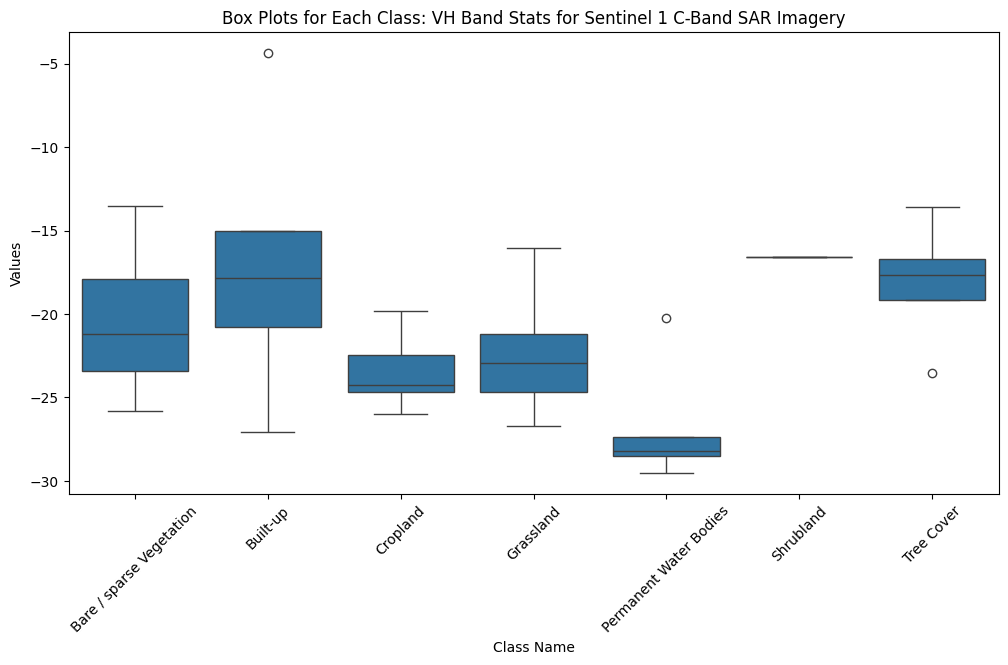

In [338]:

# Create a box plot for each class
plt.figure(figsize=(12, 6))
sns.boxplot(x='className', y='value', data=data_for_plotting_vh)
plt.title('Box Plots for Each Class: VH Band Stats for Sentinel 1 C-Band SAR Imagery')
plt.xlabel('Class Name')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

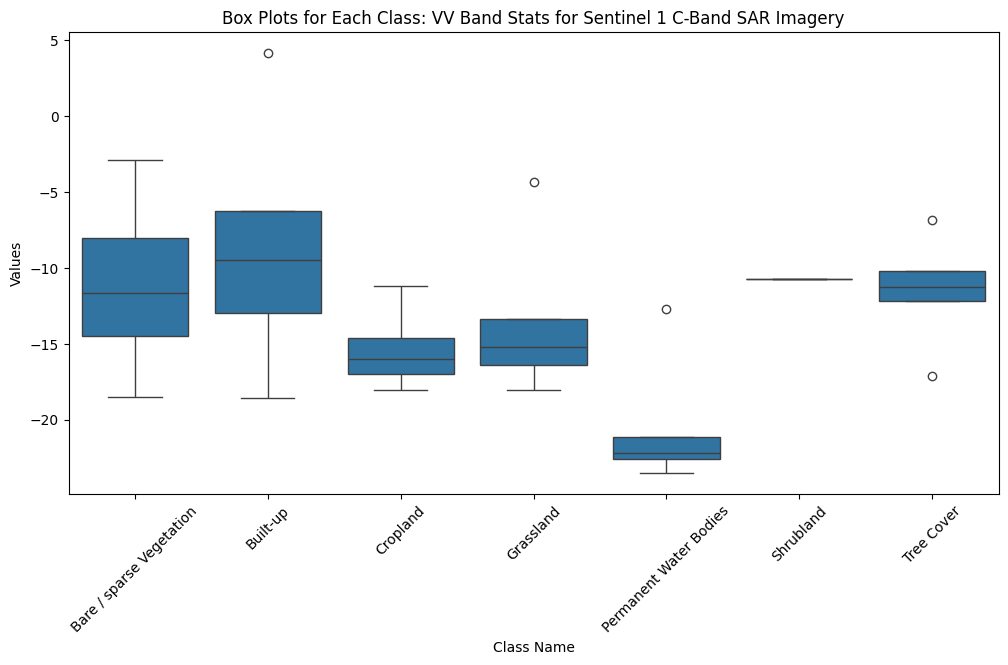

In [337]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='className', y='value', data=data_for_plotting_vv)
plt.title('Box Plots for Each Class: VV Band Stats for Sentinel 1 C-Band SAR Imagery')
plt.xlabel('Class Name')
plt.ylabel('Values')
# tilt the y axis labels
plt.xticks(rotation=45)
plt.show()